## Load the dataset

In [112]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error


normalized_data = pd.read_csv('../Normalization/A1-turbine-normalized.csv')

X = normalized_data.iloc[:, :-1].values  # select all columns except the last as features
y = normalized_data.iloc[:, -1].values  # select the last column as the target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print(f"X_train shape: {X_train.shape}")


X_train shape: (382, 4)


## Model definition

In [113]:
class MyNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, regularization_lambda=0.01, momentum_gamma=0.9):
        self.weights_input_to_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.bias_hidden = np.zeros(hidden_size)
        self.weights_hidden_to_output = np.random.randn(hidden_size, output_size) * 0.01
        self.bias_output = np.zeros(output_size)
        self.regularization_lambda = regularization_lambda
        self.momentum_gamma = momentum_gamma
        self.v_w_ih = np.zeros_like(self.weights_input_to_hidden)
        self.v_b_h = np.zeros_like(self.bias_hidden)
        self.v_w_ho = np.zeros_like(self.weights_hidden_to_output)
        self.v_b_o = np.zeros_like(self.bias_output)
        self.losses = []
        self.val_losses = []

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0) * 1

    def forward_pass(self, x):
        hidden_layer_input = np.dot(x, self.weights_input_to_hidden) + self.bias_hidden
        hidden_layer_output = self.relu(hidden_layer_input)
        output_layer_input = np.dot(hidden_layer_output, self.weights_hidden_to_output) + self.bias_output
        output = output_layer_input
        return output, hidden_layer_output

    def backward_pass(self, x, y, output, hidden_output, learning_rate):
        error = output - y
        d_weights_hidden_to_output = np.dot(hidden_output.T, error) + self.regularization_lambda * self.weights_hidden_to_output
        d_bias_output = np.sum(error, axis=0)
        d_hidden_layer = np.dot(error, self.weights_hidden_to_output.T) * self.relu_derivative(hidden_output)
        d_weights_input_to_hidden = np.dot(x.T, d_hidden_layer) + self.regularization_lambda * self.weights_input_to_hidden
        d_bias_hidden = np.sum(d_hidden_layer, axis=0)

        self.v_w_ih = (self.momentum_gamma * self.v_w_ih) + (learning_rate * d_weights_input_to_hidden)
        self.weights_input_to_hidden -= self.v_w_ih
        self.v_b_h = (self.momentum_gamma * self.v_b_h) + (learning_rate * d_bias_hidden)
        self.bias_hidden -= self.v_b_h

        self.v_w_ho = (self.momentum_gamma * self.v_w_ho) + (learning_rate * d_weights_hidden_to_output)
        self.weights_hidden_to_output -= self.v_w_ho
        self.v_b_o = (self.momentum_gamma * self.v_b_o) + (learning_rate * d_bias_output)
        self.bias_output -= self.v_b_o

    def compute_loss(self, y_true, y_pred):
        mse_loss = np.mean((y_true - y_pred) ** 2)
        l2_loss = (self.regularization_lambda / 2) * (np.sum(np.square(self.weights_input_to_hidden)) + np.sum(np.square(self.weights_hidden_to_output)))
        return mse_loss + l2_loss

    def fit(self, x, y, x_val, y_val, learning_rate, epochs, batch_size=None):
        for epoch in range(epochs):
            if batch_size is None:
                output, hidden_output = self.forward_pass(x)
                self.backward_pass(x, y, output, hidden_output, learning_rate)
                loss = self.compute_loss(y, output)
            else:
                for i in range(0, x.shape[0], batch_size):
                    x_batch = x[i:i+batch_size]
                    y_batch = y[i:i+batch_size]
                    output, hidden_output = self.forward_pass(x_batch)
                    self.backward_pass(x_batch, y_batch, output, hidden_output, learning_rate)
                output = self.predict(x)
                loss = self.compute_loss(y, output)
            
            self.losses.append(loss)

            val_output = self.predict(x_val)
            val_loss = self.compute_loss(y_val, val_output)
            self.val_losses.append(val_loss)

            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch}, Loss: {loss}, Val Loss: {val_loss}")
            
            if epoch > 10 and self.val_losses[-2] < self.val_losses[-1]:
                print("Early stopping triggered")
                break

    def predict(self, x):
        output, _ = self.forward_pass(x)
        return output

## Model training

In [114]:
param_grid = {
    'learning_rate': [0.01, 0.001],
    'epochs': [100, 500],
    'batch_size': [16, 32],
    'hidden_size': [8, 12, 16]
}

# function to perform grid search
def grid_search(param_grid):
    best_val_loss = float('inf')
    best_params = {}
    for lr in param_grid['learning_rate']:
        for epochs in param_grid['epochs']:
            for batch_size in param_grid['batch_size']:
                for hidden_size in param_grid['hidden_size']:
                    # initialize and train the neural network with current set of parameters
                    nn = MyNeuralNetwork(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1)
                    nn.fit(X_train, y_train.reshape(-1, 1), X_test, y_test.reshape(-1, 1), lr, epochs, batch_size)
                    # assume the last validation loss as the performance indicator
                    val_loss = nn.val_losses[-1]
                    print(f"LR: {lr}, Epochs: {epochs}, Batch Size: {batch_size}, Hidden Size: {hidden_size}, Val Loss: {val_loss}")
                    # update best parameters if current model is better
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_params = {'learning_rate': lr, 'epochs': epochs, 'batch_size': batch_size, 'hidden_size': hidden_size}
    return best_params

# run grid search
best_params = grid_search(param_grid)
print("Best Parameters Found:")
print(best_params)

Epoch 0, Loss: 0.06024649072627457, Val Loss: 0.0569413839056902
Epoch 10, Loss: 0.0256580294597073, Val Loss: 0.02461032282177144
Early stopping triggered
LR: 0.01, Epochs: 100, Batch Size: 16, Hidden Size: 8, Val Loss: 0.023194001355374725
Epoch 0, Loss: 0.0875999216786016, Val Loss: 0.09637446220962975
Epoch 10, Loss: 0.035025648483222344, Val Loss: 0.034995230325123645
Early stopping triggered
LR: 0.01, Epochs: 100, Batch Size: 16, Hidden Size: 12, Val Loss: 0.0344197034338259
Epoch 0, Loss: 0.07438156507077788, Val Loss: 0.0735614639917978
Epoch 10, Loss: 0.035680425368928105, Val Loss: 0.03648616177109547
Epoch 20, Loss: 0.030457008731613052, Val Loss: 0.02976118313214997
Early stopping triggered
LR: 0.01, Epochs: 100, Batch Size: 16, Hidden Size: 16, Val Loss: 0.02832807310297484
Epoch 0, Loss: 0.22314036203446438, Val Loss: 0.2327592683184458
Epoch 10, Loss: 0.04243328644804929, Val Loss: 0.04157072172424506
Epoch 20, Loss: 0.03657851758435519, Val Loss: 0.03566419743881599
Epo

## Model Evaluation

In [115]:
# assuming best_params is a dictionary containing the best parameters found by grid search
best_nn_turbine = MyNeuralNetwork(
    input_size=X_train.shape[1], 
    hidden_size=best_params['hidden_size'], 
    output_size=1
)
best_nn_turbine.fit(
    X_train, 
    y_train.reshape(-1, 1), 
    X_test, 
    y_test.reshape(-1, 1),
    best_params['learning_rate'], 
    best_params['epochs'], 
    best_params['batch_size']
)


# predictions on training data
predictions_train_turbine = best_nn_turbine.predict(X_train)
train_mape_turbine = mean_absolute_percentage_error(y_train, predictions_train_turbine)
print(f"Turbine Data Training MAPE: {train_mape_turbine:.2f}%")

# predictions on test data
# ensure that X_test and y_test are defined and hold your test dataset
predictions_test_turbine = best_nn_turbine.predict(X_test)
test_mape_turbine = mean_absolute_percentage_error(y_test, predictions_test_turbine)
print(f"Turbine Data Test MAPE: {test_mape_turbine:.2f}%")


Epoch 0, Loss: 0.9692259570975613, Val Loss: 1.1510401790227236
Epoch 10, Loss: 0.02267537314670943, Val Loss: 0.021016467126366303
Early stopping triggered
Turbine Data Training MAPE: 0.38%
Turbine Data Test MAPE: 0.12%


## Predictions vs Actual Values Plot

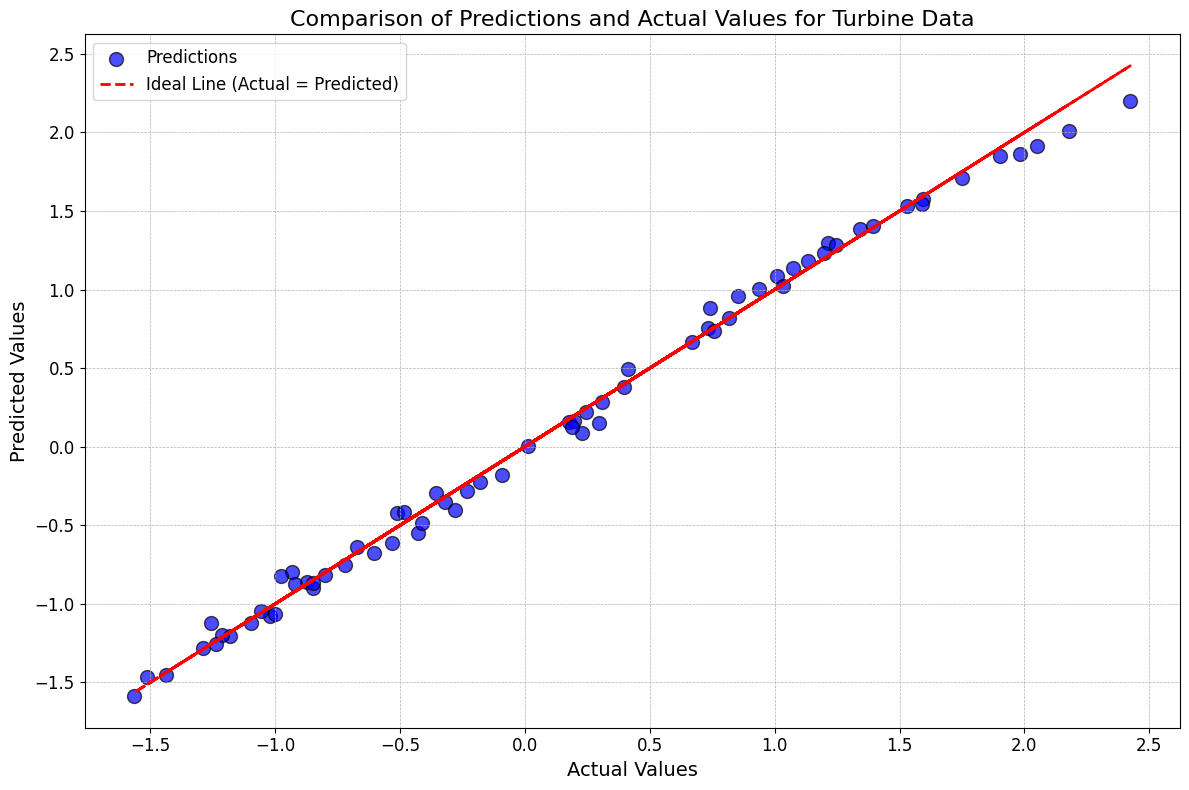

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(y_test, predictions_test_turbine, color='blue', edgecolor='k', label='Predictions', alpha=0.7, marker='o', s=100)
plt.plot(y_test, y_test, color='red', label='Ideal Line (Actual = Predicted)', linewidth=2, linestyle='--')
plt.title('Comparison of Predictions and Actual Values for Turbine Data', fontsize=16)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
